In [337]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from Scripts.dirty_accuracy import injection
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

## Helper functions

Naive Bayes Classification implementation

In [338]:
def NBClassification(X_train, y_train, X_test, y_test):
    nb = GaussianNB()
    nb.fit(X_train, y_train)
    training_score = nb.score(X_train, y_train)
    test_score = nb.score(X_test, y_test)
    return [training_score, test_score]

Decision Tree Classification implementation

In [339]:
def DTClassification(X_train, y_train, X_test, y_test):
    dtc = DecisionTreeClassifier()
    dtc.fit(X_train, y_train)
    training_score = dtc.score(X_train, y_train)
    test_score = dtc.score(X_test, y_test)
    return [training_score, test_score]

Data Classification implementation that turns all categorical columns into numerical values

In [340]:
def DCmap(df):
    dataset = df.copy()
    for col in dataset:
        if dataset[col].dtype == object:
            to_replace = dataset[col].unique()
            value = []
            for i in range (len(to_replace)):
                value.append(i)
            dataset[col] = dataset[col].replace(to_replace=to_replace, value=value)
    return dataset

Print scores

In [341]:
def printScores(scores):
    for score in scores:
        print("Dataset dirty at: ", score['dirty'], "%")
        print(score['scores'][0],':', score['scores'][1])

IRQ detection and correction

In [342]:
def IRQ(data, ids):
    ids = ids + 1
    Q1, Q3 = np.percentile(data, [5*ids, 100 - (5*ids)])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    outliers = data[((data < lower_range) | (data > upper_range))]
    for i in range(len(data)):
        if data[i] in outliers:
            data[i] = (lower_range + upper_range)/2
    return data

K-Means detection and correction

In [343]:
def KMeansDetectionColumn(data, col, ids):
    km = KMeans(n_clusters=2)
    clusters = km.fit_predict(data)
    centroids = km.cluster_centers_
    distances = np.empty((0,len(data[col])), float)
    for i, center_elem in enumerate(centroids):
        distances = np.append(distances, cdist([center_elem],data[clusters == i], 'euclidean'))
    d_df = pd.DataFrame(distances, columns=['distances'])
    data = pd.concat([data, d_df], axis=1)
    percentile = 100-(10*ids)
    outliers = data[data['distances']  > np.percentile(distances, percentile)]
    not_outliers = data[data['distances']  <= np.percentile(distances, percentile)]
    mean = not_outliers[col].mean()
    data.loc[outliers.index, col] = mean
    return data[col]

In [344]:
def KMeansDetection(data, i):
    columns = ["Sex","Housing","Saving_accounts","Checking_account","Purpose"]
    for col in data.columns:
        if col not in columns:
            columns.append(col)
            data[col] = KMeansDetectionColumn(data[columns], col, i)
    return data

## Pipeline implementation

Read the dataset from CSV file

In [345]:
german = pd.read_csv("datasets/german.csv", sep=',')
ss = StandardScaler()
literal_cols = ["Sex","Housing","Saving_accounts","Checking_account","Purpose", "Risk"]
numerical_cols = ["Age", "Job", "Credit_amount", "Duration"]
german_str = german[literal_cols]
german_num = german[numerical_cols]
german_num = pd.DataFrame(ss.fit_transform(german_num), columns=numerical_cols)
german = pd.concat([german_str, german_num], axis=1)

Perform the injections of outliers
and append the original clean dataset to the list

In [346]:
german_list = injection(df_pandas=german, seed=10, name='german', name_class='Risk')
german_list.append(german)
for i in range(len(german_list)):
    german_list[i] = DCmap(german_list[i])

saved german-accuracy50%
saved german-accuracy60%
saved german-accuracy70%
saved german-accuracy80%
saved german-accuracy90%


Reverse the list on order to have
0 - Original Dataset
1 - 10% Dirty dataset
2 - 20% Dirty dataset
3 - 30% Dirty dataset
4 - 40% Dirty dataset
5 - 50% Dirty dataset

In [347]:
german_list.reverse()

### Functions to be repeated for each dataframe

In [348]:
def computeScoresDT(dataframe_array):
    y = german['Risk']
    scores = []
    i = 0
    for df in dataframe_array:
        X = df.drop('Risk', axis=1, errors='ignore')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        sc = DTClassification(X_train, y_train, X_test, y_test)
        scores.append({'dirty': i, 'scores': sc})
        i = i + 10
    return scores

In [349]:
def computeScoresNB(dataframe_array):
    y = german['Risk']
    scores = []
    i = 0
    for df in dataframe_array:
        X = df.drop('Risk', axis=1, errors='ignore')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        sc = NBClassification(X_train, y_train, X_test, y_test)
        scores.append({'dirty': i, 'scores': sc})
        i = i + 10
    return scores

In [350]:
def cleanDatasetsIRQ(datasets):
    cleaned_list = []
    i=0
    for df in datasets:
        cleaned = df.copy()
        for col in cleaned.columns:
            if col not in ["Sex","Housing","Saving_accounts","Checking_account","Purpose", "Risk"]:
                cleaned[col] = IRQ(cleaned[col].values, i)
        cleaned_list.append(cleaned)
        i = i + 1
    return cleaned_list

In [351]:
def cleanDatasetKMeans(datasets):
    cleaned_list = []
    i=0
    for df in datasets:
        cleaned = df.copy()
        cleaned = cleaned.drop('Risk', axis=1)
        cleaned = KMeansDetection(cleaned, i)
        cleaned_list.append(cleaned)
        i=i+1
    return cleaned_list

Compute scores

In [352]:
DTscores = computeScoresDT(german_list)
printScores(DTscores)

Dataset dirty at:  0 %
1.0 : 0.6466666666666666
Dataset dirty at:  10 %
1.0 : 0.6133333333333333
Dataset dirty at:  20 %
1.0 : 0.61
Dataset dirty at:  30 %
1.0 : 0.59
Dataset dirty at:  40 %
1.0 : 0.63
Dataset dirty at:  50 %
1.0 : 0.62


In [353]:
NBscore = computeScoresNB(german_list)
printScores(NBscore)

Dataset dirty at:  0 %
0.6885714285714286 : 0.7266666666666667
Dataset dirty at:  10 %
0.6742857142857143 : 0.67
Dataset dirty at:  20 %
0.6842857142857143 : 0.6666666666666666
Dataset dirty at:  30 %
0.6814285714285714 : 0.6566666666666666
Dataset dirty at:  40 %
0.68 : 0.64
Dataset dirty at:  50 %
0.6928571428571428 : 0.6566666666666666


Find column by column outliers using IRQ and K-Means and replace them with mean value

In [354]:
cleaned_irq_lists = cleanDatasetsIRQ(german_list)
cleaned_km_list = cleanDatasetKMeans(german_list)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

Perform again the classification after outliers detection and print results

In [355]:
cleaned_DTscores_irq = computeScoresDT(cleaned_irq_lists)
cleaned_NBscores_irq = computeScoresNB(cleaned_irq_lists)
cleaned_DTscores_km = computeScoresDT(cleaned_km_list)
cleaned_NBscores_km = computeScoresNB(cleaned_km_list)

In [356]:
printScores(cleaned_DTscores_irq)

Dataset dirty at:  0 %
1.0 : 0.66
Dataset dirty at:  10 %
1.0 : 0.63
Dataset dirty at:  20 %
1.0 : 0.6533333333333333
Dataset dirty at:  30 %
1.0 : 0.5833333333333334
Dataset dirty at:  40 %
0.99 : 0.6
Dataset dirty at:  50 %
0.9814285714285714 : 0.5966666666666667


In [357]:
printScores(cleaned_NBscores_irq)

Dataset dirty at:  0 %
0.6885714285714286 : 0.7266666666666667
Dataset dirty at:  10 %
0.6857142857142857 : 0.7166666666666667
Dataset dirty at:  20 %
0.6928571428571428 : 0.7066666666666667
Dataset dirty at:  30 %
0.6885714285714286 : 0.6533333333333333
Dataset dirty at:  40 %
0.6985714285714286 : 0.7033333333333334
Dataset dirty at:  50 %
0.68 : 0.69


In [358]:
printScores(cleaned_DTscores_km)

Dataset dirty at:  0 %
1.0 : 0.65
Dataset dirty at:  10 %
1.0 : 0.5933333333333334
Dataset dirty at:  20 %
0.9985714285714286 : 0.62
Dataset dirty at:  30 %
0.9971428571428571 : 0.63
Dataset dirty at:  40 %
0.9985714285714286 : 0.5333333333333333
Dataset dirty at:  50 %
0.9914285714285714 : 0.5566666666666666


In [359]:
printScores(cleaned_NBscores_km)

Dataset dirty at:  0 %
0.6885714285714286 : 0.7266666666666667
Dataset dirty at:  10 %
0.6771428571428572 : 0.68
Dataset dirty at:  20 %
0.6814285714285714 : 0.65
Dataset dirty at:  30 %
0.6871428571428572 : 0.6566666666666666
Dataset dirty at:  40 %
0.69 : 0.6566666666666666
Dataset dirty at:  50 %
0.6871428571428572 : 0.6733333333333333


### Plot data preparation

Transform the score object array into an array of test scores

In [360]:
def toArray(score):
    t = []
    for s in score:
        t.append(s['scores'][1])
    return t

Preparation of plot DataFrame

In [361]:
plotData = {
    'dirty': [0, 10, 20, 30, 40, 50],
    'DTc_pre': toArray(DTscores),
    'NB_pre': toArray(NBscore),
    'DTc_irq_post': toArray(cleaned_DTscores_irq),
    'NB_irq_post': toArray(cleaned_NBscores_irq),
    'DTc_km_post': toArray(cleaned_DTscores_km),
    'NB_km_post': toArray(cleaned_NBscores_km)
}
plotDF = pd.DataFrame(plotData)

#### Comparison between pre and post detection scores for each combination of algorithms

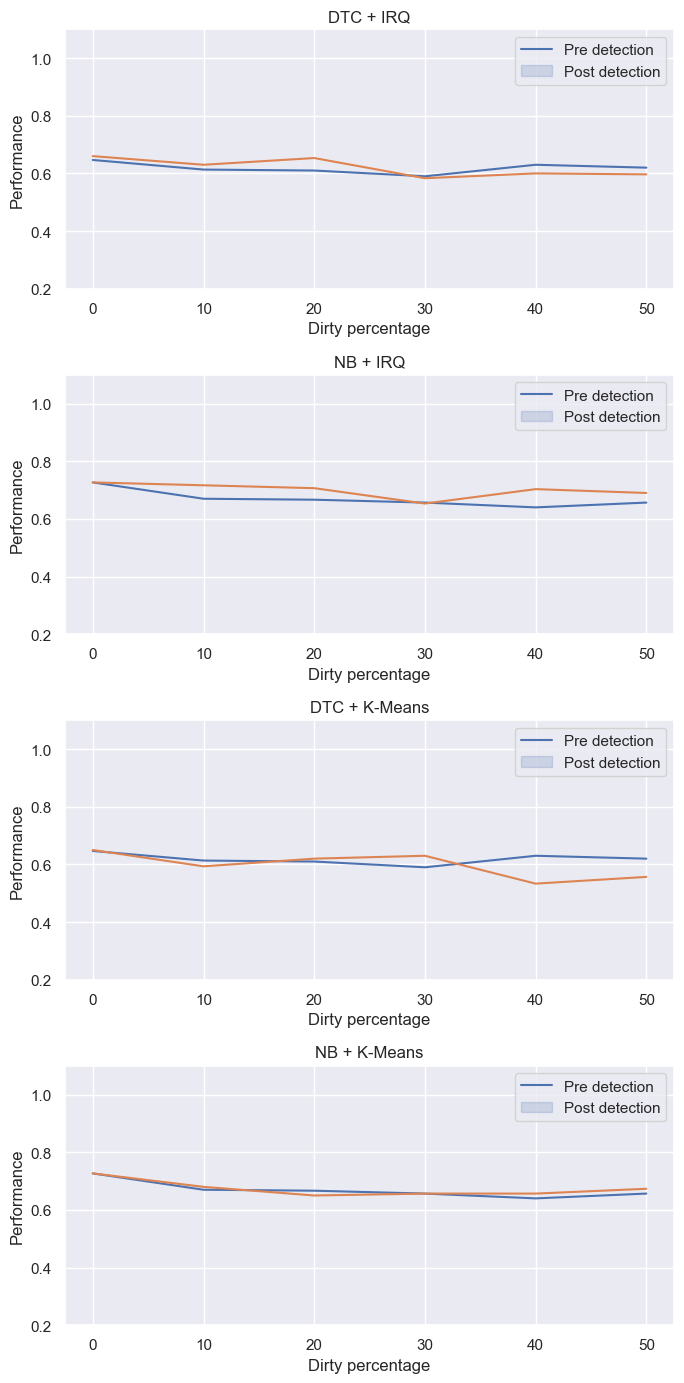

In [362]:
sns.set()
fig, axes = plt.subplots(4, 1, sharex=False, figsize=(7,14))

sns.lineplot(ax=axes[0], x='dirty', y='DTc_pre', data=plotDF)
sns.lineplot(ax=axes[0], x='dirty', y='DTc_irq_post', data=plotDF)
axes[0].legend(['Pre detection', 'Post detection'])
axes[0].set(xlabel='Dirty percentage', ylabel='Performance')
axes[0].set_ylim(0.2,1.1)
axes[0].set_title('DTC + IRQ')

sns.lineplot(ax=axes[1], x='dirty', y='NB_pre', data=plotDF)
sns.lineplot(ax=axes[1], x='dirty', y='NB_irq_post', data=plotDF)
axes[1].legend(['Pre detection', 'Post detection'])
axes[1].set(xlabel='Dirty percentage', ylabel='Performance')
axes[1].set_ylim(0.2,1.1)
axes[1].set_title('NB + IRQ')

sns.lineplot(ax=axes[2], x='dirty', y='DTc_pre', data=plotDF)
sns.lineplot(ax=axes[2], x='dirty', y='DTc_km_post', data=plotDF)
axes[2].legend(['Pre detection', 'Post detection'])
axes[2].set(xlabel='Dirty percentage', ylabel='Performance')
axes[2].set_ylim(0.2,1.1)
axes[2].set_title('DTC + K-Means')

sns.lineplot(ax=axes[3], x='dirty', y='NB_pre', data=plotDF)
sns.lineplot(ax=axes[3], x='dirty', y='NB_km_post', data=plotDF)
axes[3].legend(['Pre detection', 'Post detection'])
axes[3].set(xlabel='Dirty percentage', ylabel='Performance')
axes[3].set_ylim(0.2,1.1)
axes[3].set_title('NB + K-Means')
fig.tight_layout()

#### Comparison between the two classification algorithms pre-detection and post-detection (for each outlier detection algorithm)

Text(0.5, 1.0, 'Post detection K-Means performances')

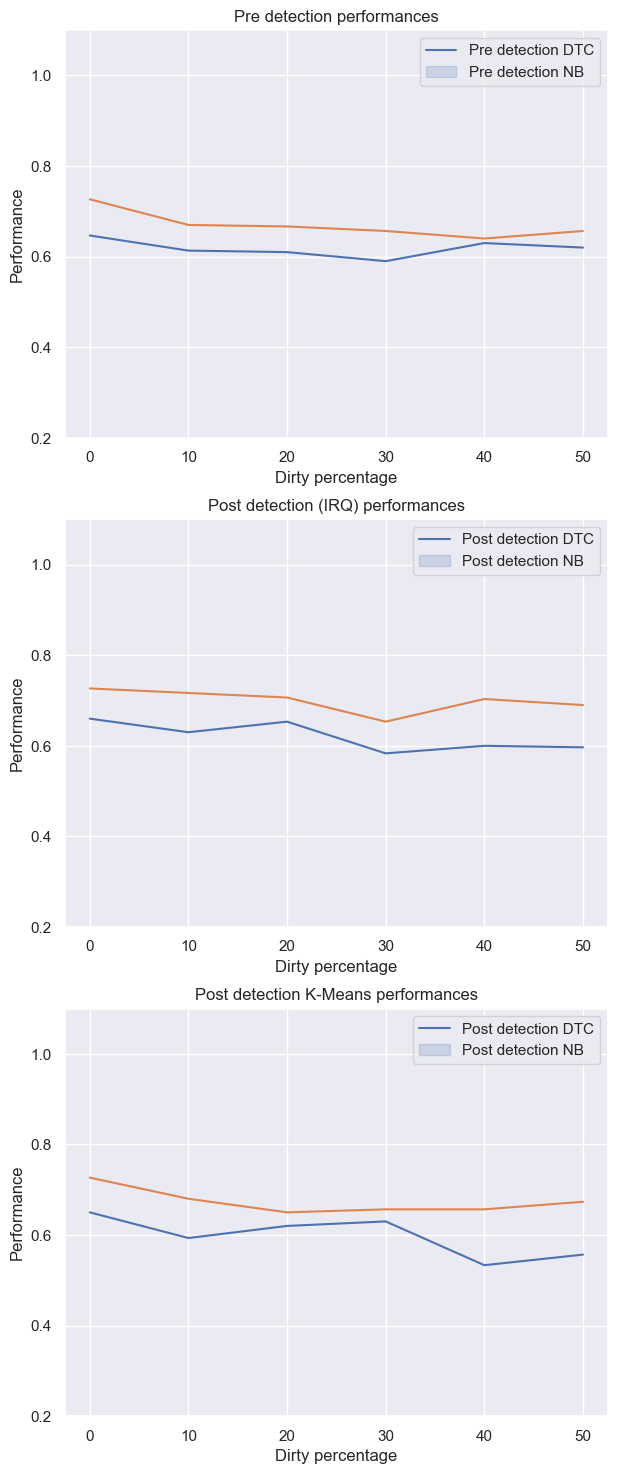

In [363]:
sns.set()
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(7,18))

sns.lineplot(ax=axes[0], x='dirty', y='DTc_pre', data=plotDF)
sns.lineplot(ax=axes[0], x='dirty', y='NB_pre', data=plotDF)
axes[0].legend(['Pre detection DTC', 'Pre detection NB'])
axes[0].set(xlabel='Dirty percentage', ylabel='Performance')
axes[0].set_ylim(0.2,1.1)
axes[0].set_title('Pre detection performances')

sns.lineplot(ax=axes[1], x='dirty', y='DTc_irq_post', data=plotDF)
sns.lineplot(ax=axes[1], x='dirty', y='NB_irq_post', data=plotDF)
axes[1].legend(['Post detection DTC', 'Post detection NB'])
axes[1].set(xlabel='Dirty percentage', ylabel='Performance')
axes[1].set_ylim(0.2,1.1)
axes[1].set_title('Post detection (IRQ) performances')

sns.lineplot(ax=axes[2], x='dirty', y='DTc_km_post', data=plotDF)
sns.lineplot(ax=axes[2], x='dirty', y='NB_km_post', data=plotDF)
axes[2].legend(['Post detection DTC', 'Post detection NB'])
axes[2].set(xlabel='Dirty percentage', ylabel='Performance')
axes[2].set_ylim(0.2,1.1)
axes[2].set_title('Post detection K-Means performances')

#### Comparison between detection algorithms for each post-detection one

Text(0.5, 1.0, 'NB Post-detection performances')

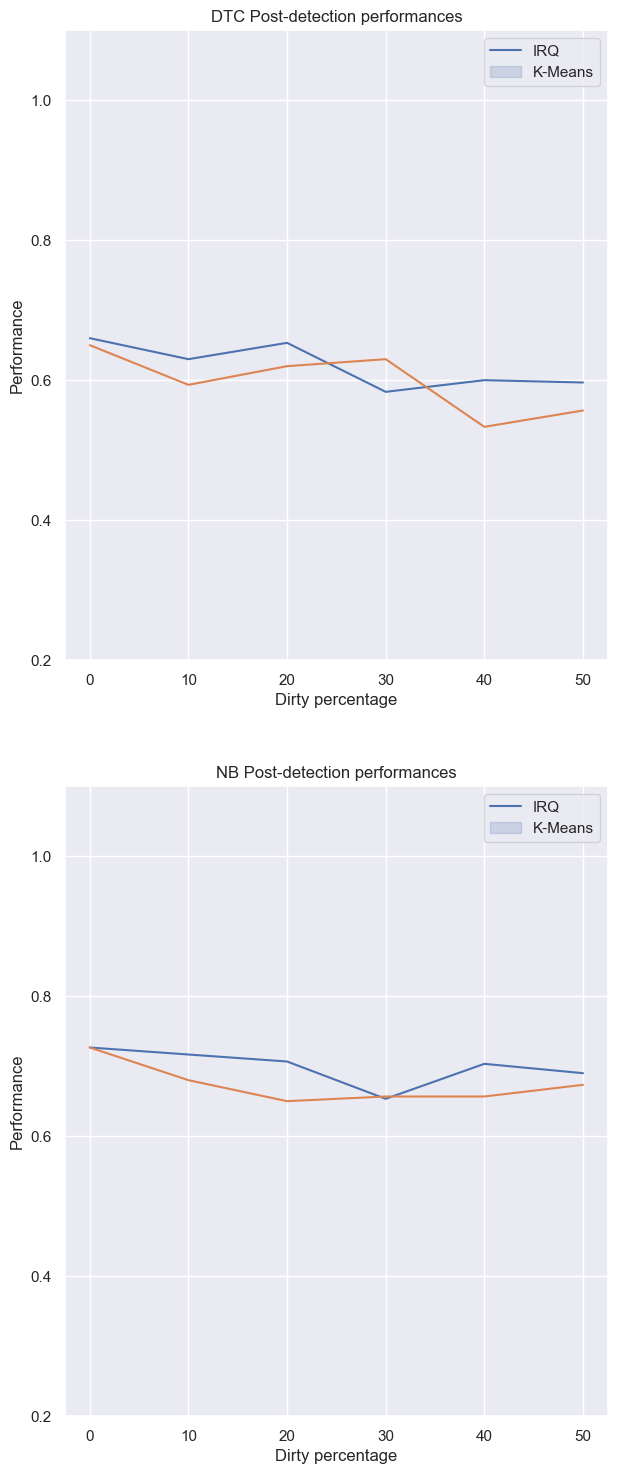

In [364]:
sns.set()
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(7,18))

sns.lineplot(ax=axes[0], x='dirty', y='DTc_irq_post', data=plotDF)
sns.lineplot(ax=axes[0], x='dirty', y='DTc_km_post', data=plotDF)
axes[0].legend(['IRQ', 'K-Means'])
axes[0].set(xlabel='Dirty percentage', ylabel='Performance')
axes[0].set_ylim(0.2,1.1)
axes[0].set_title('DTC Post-detection performances')

sns.lineplot(ax=axes[1], x='dirty', y='NB_irq_post', data=plotDF)
sns.lineplot(ax=axes[1], x='dirty', y='NB_km_post', data=plotDF)
axes[1].legend(['IRQ', 'K-Means'])
axes[1].set(xlabel='Dirty percentage', ylabel='Performance')
axes[1].set_ylim(0.2,1.1)
axes[1].set_title('NB Post-detection performances')